In [ ]:
import sys
sys.path.append('../../ovdsat')

In [ ]:
from utils_dir.backbones_utils import extract_backbone_features, load_backbone
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as pth_transforms

In [ ]:
backbone_type = 'dinov2'

In [ ]:
backbone = load_backbone(backbone_type) 

In [ ]:
print(backbone)

In [ ]:
print(backbone.blocks[0].attn.num_heads, 'attention heads')

In [ ]:
print(len(backbone.blocks), 'blocks')

In [ ]:
img0 = Image.open('/home/gridsan/manderson/ovdsat/data/simd/val/4220.jpg')
img0 = img0.convert('RGB')

plt.imshow(img0)
print(np.array(img0).shape)

In [ ]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img0)
print(img.shape)

patch_size = backbone.patch_embed.patch_size[0]
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

print(img.shape)

In [ ]:
attentions = backbone.get_last_selfattention(img)

In [ ]:
attention_maps = []

def get_attention(module, input, output):
    attention_maps.append(output)

i=0
for name, module in backbone.named_modules():
    if 'attn' in name and len(name) < 15:
        i+=1
        print(name)
        module.register_forward_hook(get_attention)
print(i)

In [ ]:
with torch.no_grad():
    output = backbone(img)

In [ ]:
print(len(attention_maps))
print(attention_maps[0].shape)

### New attempt 
* https://github.com/huggingface/pytorch-image-models/discussions/1232
* https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from torchvision import transforms as pth_transforms
from utils_dir.backbones_utils import extract_backbone_features, load_backbone

In [7]:
def to_tensor(img, patch_size):
    #transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    #return transform_fn(img)
    transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h]
    return img

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
    
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0] * attn_obj.scale, qkv[1], qkv[2]
        attn = q @ k.transpose(-2, -1)

        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        
        return x

    return my_forward

In [ ]:
        '''
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
        '''

In [3]:
# Load backbone
model = load_backbone('dinov2') 
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
num_heads = model.blocks[0].attn.num_heads
print(num_heads, 'attention heads')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


16 attention heads


patch size: 14
torch.Size([3, 756, 1022])
Feature size: 54 73


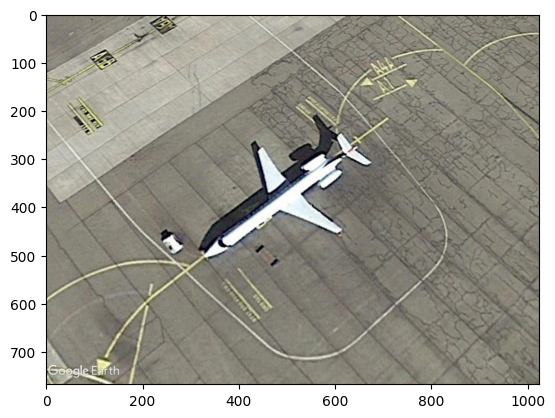

In [16]:
# Load and format image
patch_size = model.patch_embed.patch_size[0]
print('patch size:', patch_size)
img = Image.open('/home/gridsan/manderson/ovdsat/data/simd/val/0201.jpg')
plt.imshow(img)
x = to_tensor(img, patch_size)
print(x.shape) #torch.Size([1, 3, 756, 1022])
w_featmap = x.shape[-2] // patch_size
h_featmap = x.shape[-1] // patch_size
print('Feature size:', w_featmap, h_featmap)

In [17]:
# Pass image and extract attention maps
y = model(x.unsqueeze(0))
attn_maps = model.blocks[-1].attn.attn_map.squeeze(0)
print(attn_maps.shape)

torch.Size([16, 3943, 3943])


In [18]:
# Extract CLS attention to all other tokens
attn = attn_maps[:, 0, 1:].reshape(num_heads, w_featmap, h_featmap)
attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attn.shape)
attn_mean = np.mean(attn, axis=0)
print(attn_mean.shape)

(16, 756, 1022)
(756, 1022)


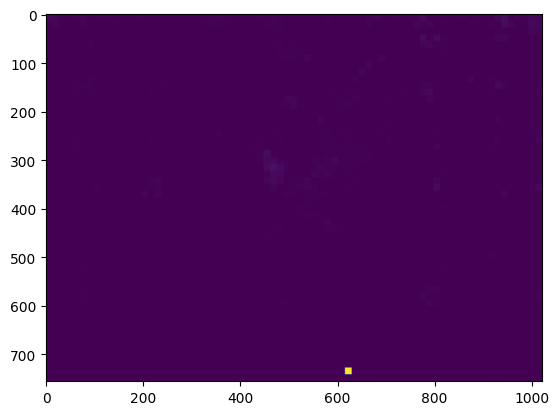

In [19]:
plt.imshow(attn[0])